In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_excel('Lithium import Forecasting.xlsx')
df_total = df[df['Country/Region'] == 'Total'].drop(columns=['Country/Region', 'Total'])

In [3]:
df_long = df_total.melt(var_name='Date_Str', value_name='Value')

In [4]:
df_long['Date'] = pd.to_datetime(df_long['Date_Str'], format='%b-%Y')
df_long = df_long.sort_values('Date').set_index('Date')
series = df_long['Value']

In [5]:
df_long.head(10)

,Date_Str,Value
Date,,
2017-01-01,Jan-2017,3.33
2017-02-01,Feb-2017,3.39
2017-03-01,Mar-2017,6.49
2017-04-01,Apr-2017,8.18
2017-05-01,May-2017,9.41
2017-06-01,Jun-2017,4.38
2017-07-01,Jul-2017,6.20
2017-08-01,Aug-2017,6.10
2017-09-01,Sep-2017,4.86


In [6]:
result = adfuller(series.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}") # data is stationary d=0

ADF Statistic: -4.0431
p-value: 0.0012


In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

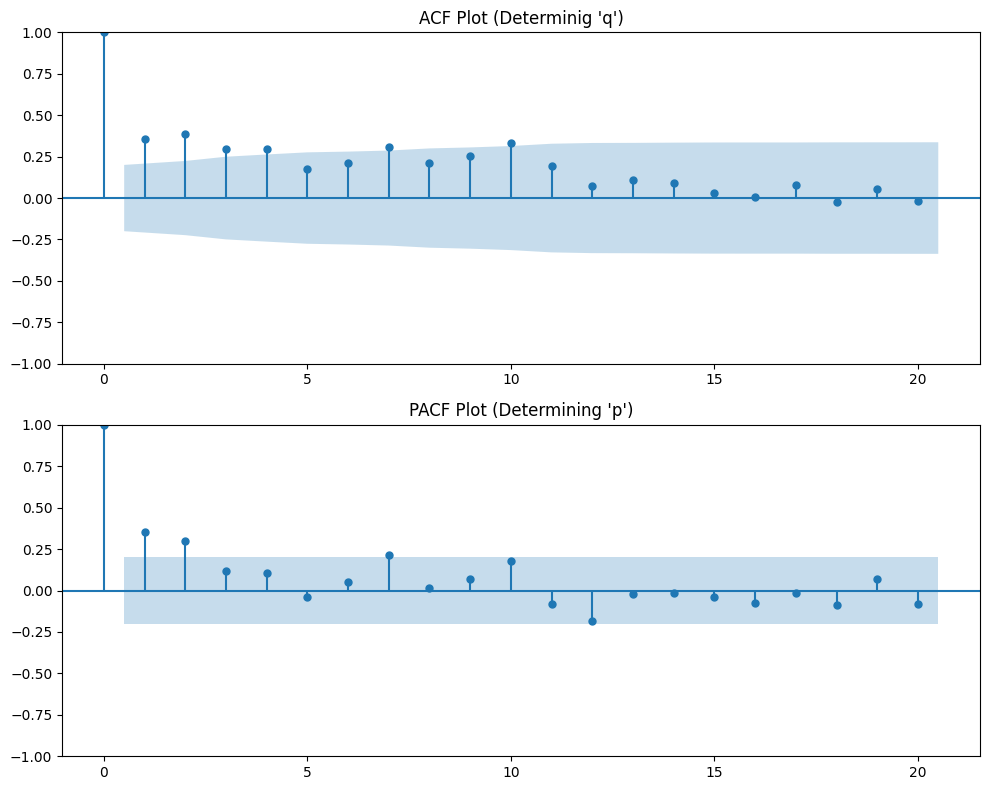

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF (Determine q)
plot_acf(series, lags=20, ax=ax1, title="ACF Plot (Determinig 'q')") # q=3

# Plot PACF (Determine p)
plot_pacf(series, lags=20, ax=ax2, title="PACF Plot (Determining 'p')") # p=2

plt.tight_layout()
plt.show()

# (p,d,q) = (2,0,3)

<Figure size 1000x400 with 0 Axes>

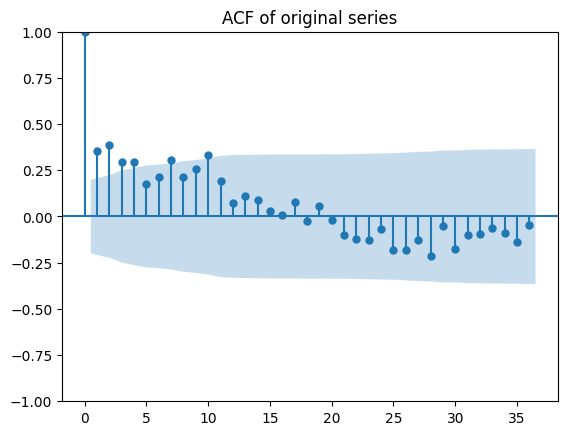

In [14]:
s=12
plt.figure(figsize=(10,4))
plot_acf(series, lags=3*s)
plt.title("ACF of original series")
plt.show()

In [15]:
seasonal_diff = series.diff(s).dropna()

<Figure size 1000x400 with 0 Axes>

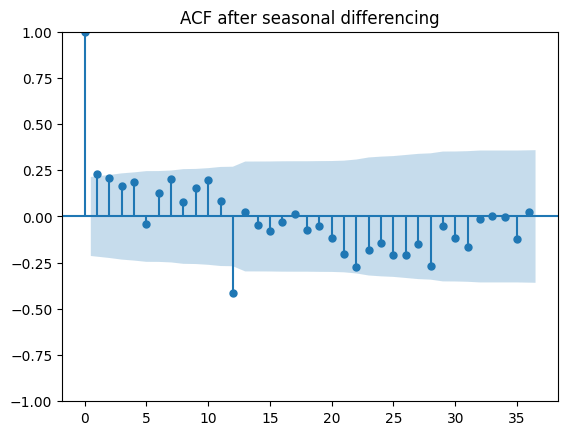

In [16]:
plt.figure(figsize=(10,4))
plot_acf(seasonal_diff, lags=3*s)
plt.title("ACF after seasonal differencing")
plt.show()

In [17]:
final_series = seasonal_diff


<Figure size 1200x500 with 0 Axes>

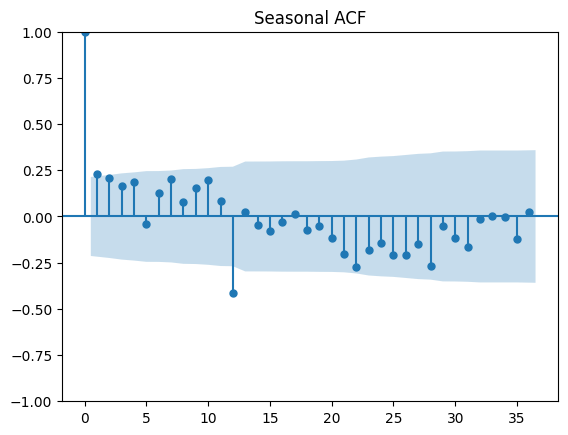

<Figure size 1200x500 with 0 Axes>

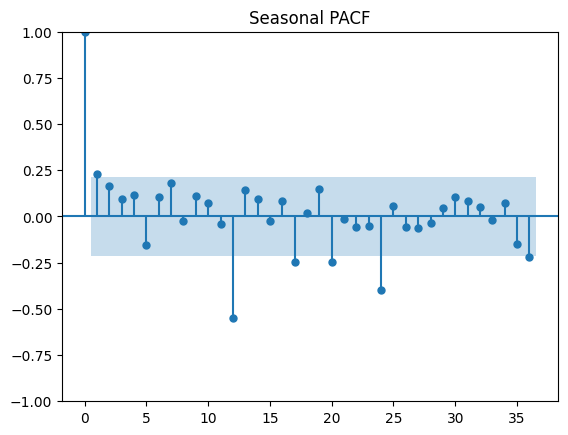

In [21]:
plt.figure(figsize=(12,5))
plot_acf(final_series, lags=3*s)
plt.title("Seasonal ACF")
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(final_series, lags=3*s)
plt.title("Seasonal PACF")
plt.show()

# (P,D,Q,s) = (1,1,1,12)

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

In [55]:
train_data = series.iloc[:-12]
test_data = series.iloc[-12:]

In [56]:
model = SARIMAX(train_data,
                order=(2, 0, 2),
                seasonal_order=(1, 1, 1, 12))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [57]:
model_fit = model.fit(disp=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [58]:
# validation
forecast = model_fit.get_forecast(steps=12)
pred_values = forecast.predicted_mean
conf_int = forecast.conf_int()

In [59]:
rmse = np.sqrt(mean_squared_error(test_data, pred_values))
print(f"Model Performance (RMSE): {rmse:.2f}") # 3.07 , 2.54 (1,0,1) , 3.05 , 2.68 (2,0,1) , 2.36 (2,0,2)

Model Performance (RMSE): 2.36


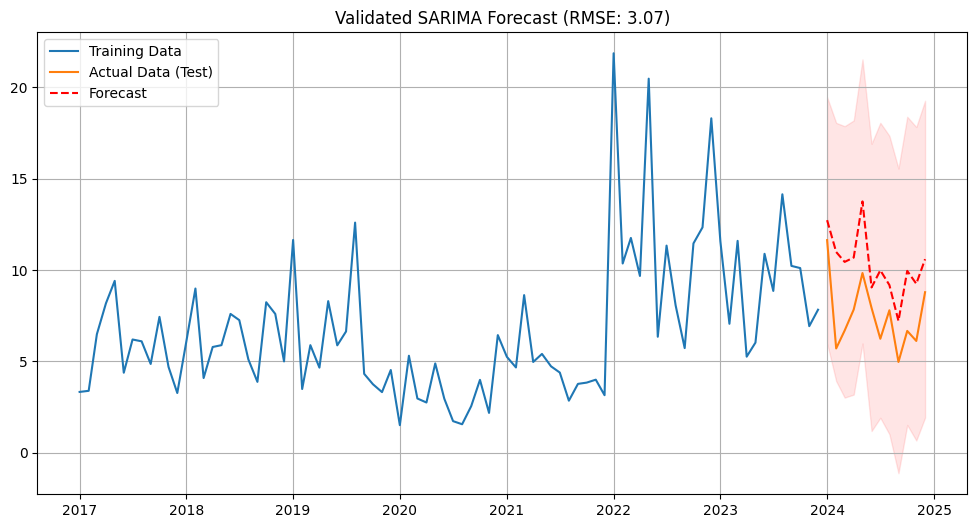

In [27]:
# Plotting the Result
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data (Test)')
plt.plot(test_data.index, pred_values, label='Forecast', color='red', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='red', alpha=0.1)
plt.title(f'Validated SARIMA Forecast (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()

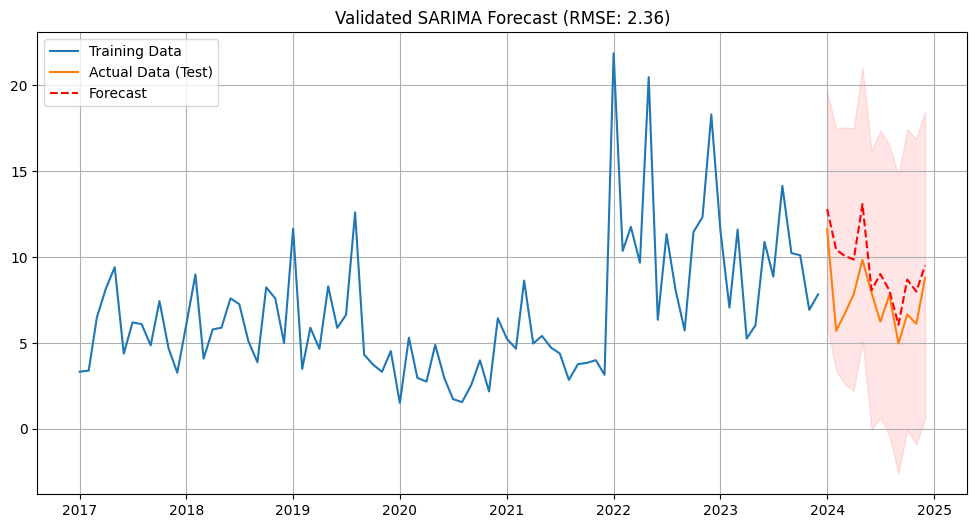

In [60]:
# Plotting the Result
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data (Test)')
plt.plot(test_data.index, pred_values, label='Forecast', color='red', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='red', alpha=0.1)
plt.title(f'Validated SARIMA Forecast (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# 3. Apply Log Transformation
train_log = np.log(train_data)

In [63]:
model = SARIMAX(train_log,
                order=(2, 0, 2),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
pred_log = model_fit.get_forecast(steps=12)
pred_log_mean = pred_log.predicted_mean
pred_log_ci = pred_log.conf_int()


In [66]:
pred_final = np.exp(pred_log_mean)
conf_int_final = np.exp(pred_log_ci)
rmse = np.sqrt(mean_squared_error(test_data, pred_final))
print(f"Log-Transform RMSE:   {rmse:.4f}")

Log-Transform RMSE:   2.0038


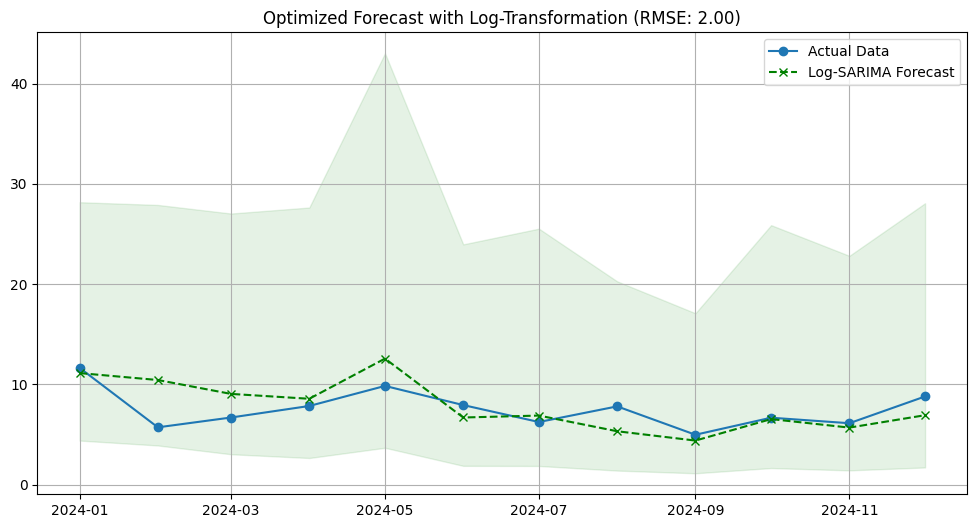

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Data', marker='o')
plt.plot(test_data.index, pred_final, label='Log-SARIMA Forecast', linestyle='--', color='green', marker='x')
plt.fill_between(test_data.index, conf_int_final.iloc[:,0], conf_int_final.iloc[:,1], color='green', alpha=0.1)
plt.title(f'Optimized Forecast with Log-Transformation (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()

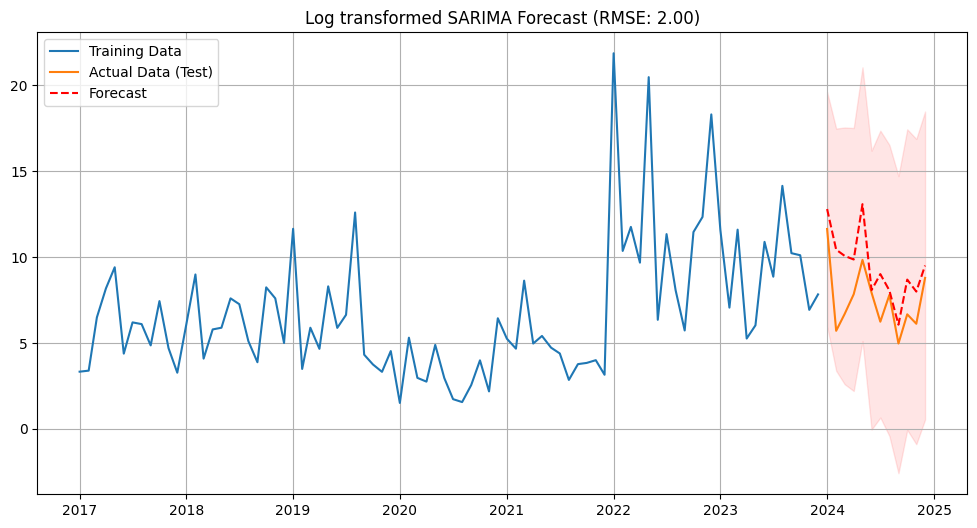

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data (Test)')
plt.plot(test_data.index, pred_values, label='Forecast', color='red', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='red', alpha=0.1)
plt.title(f'Log transformed SARIMA Forecast (RMSE: {rmse:.2f})')
plt.legend()
plt.grid(True)
plt.show()